In [1]:
import pandas as pd
import common as ag
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [140]:
elev = np.array(Image.open(project_dir + "tmp/elev.tif"))

In [162]:
elev.shape

(1800, 3000)

In [163]:
elev.max(), elev.min()

(358, 84)

(2000, 3000)

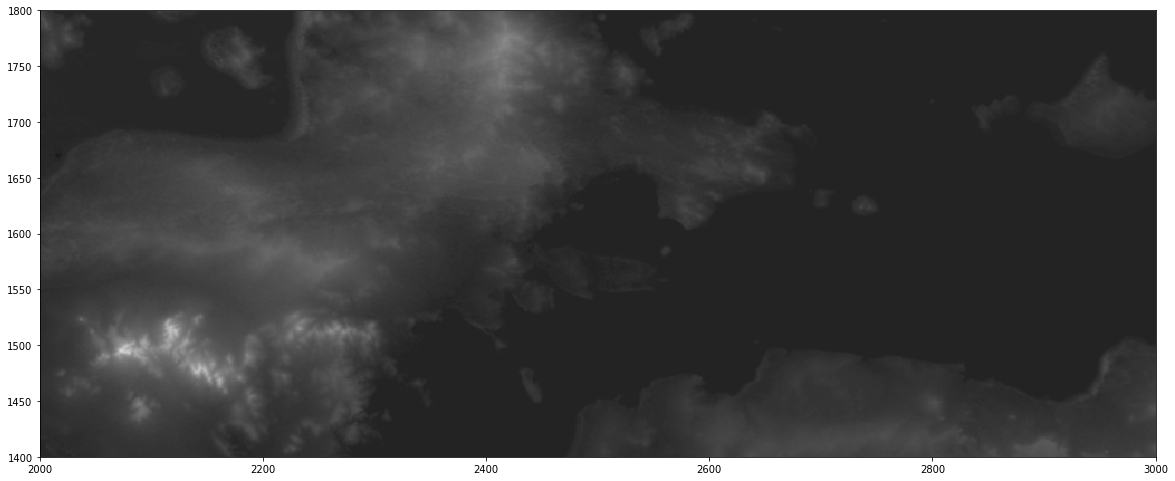

In [168]:
plt.figure(figsize=(20,10))
plt.imshow(elev, vmin=84, vmax=350, cmap="gray" )
plt.ylim(1400, 1800)
plt.xlim(2000, 3000)

In [4]:
import geopandas
from scipy.interpolate import splprep, splev

# load shp
shapefile = geopandas.read_file("/home/tom/csiro/src/lpr/projects/gawler/training/gawler.shp")
geoms = shapefile.geometry.values # list of shapely geometries


In [6]:
geoms

array([<shapely.geometry.polygon.Polygon object at 0x7fa665c1d9e8>,
      dtype=object)

In [30]:
# bounding boxes
for i, the_class in enumerate(geoms):
    x, y = the_class.exterior.xy
    #print(x, y)
    x = np.array(x)
    y = np.array(y)
    print ("%i & %9.5f & %9.5f & %9.5f & %9.5f\\\\" % (i, x.min(), x.max(), y.min(), y.max()))

0 & 133.87407 & 134.39661 & -30.49787 & -30.07369\\
1 & 134.42120 & 134.85153 & -30.79910 & -30.44562\\
2 & 133.65276 & 134.11997 & -31.33701 & -30.96509\\
3 & 134.39354 & 134.93760 & -31.40771 & -31.04808\\
4 & 135.34333 & 135.73370 & -30.90054 & -30.55935\\


In [13]:
np.array(x)

135.34333376024045

In [23]:
6400e3*2*3.1415/360*np.cos(np.deg2rad(30.75))*0.00001 #* (136-133.5)

0.9599378637268672

1183.8455049389097 1717.7189242553752
839.5529292151182 1267.8283564009475
184.68704411046843 655.0459222542457
107.10834755308696 556.4951791328567
718.2325097396742 1132.7236906932087


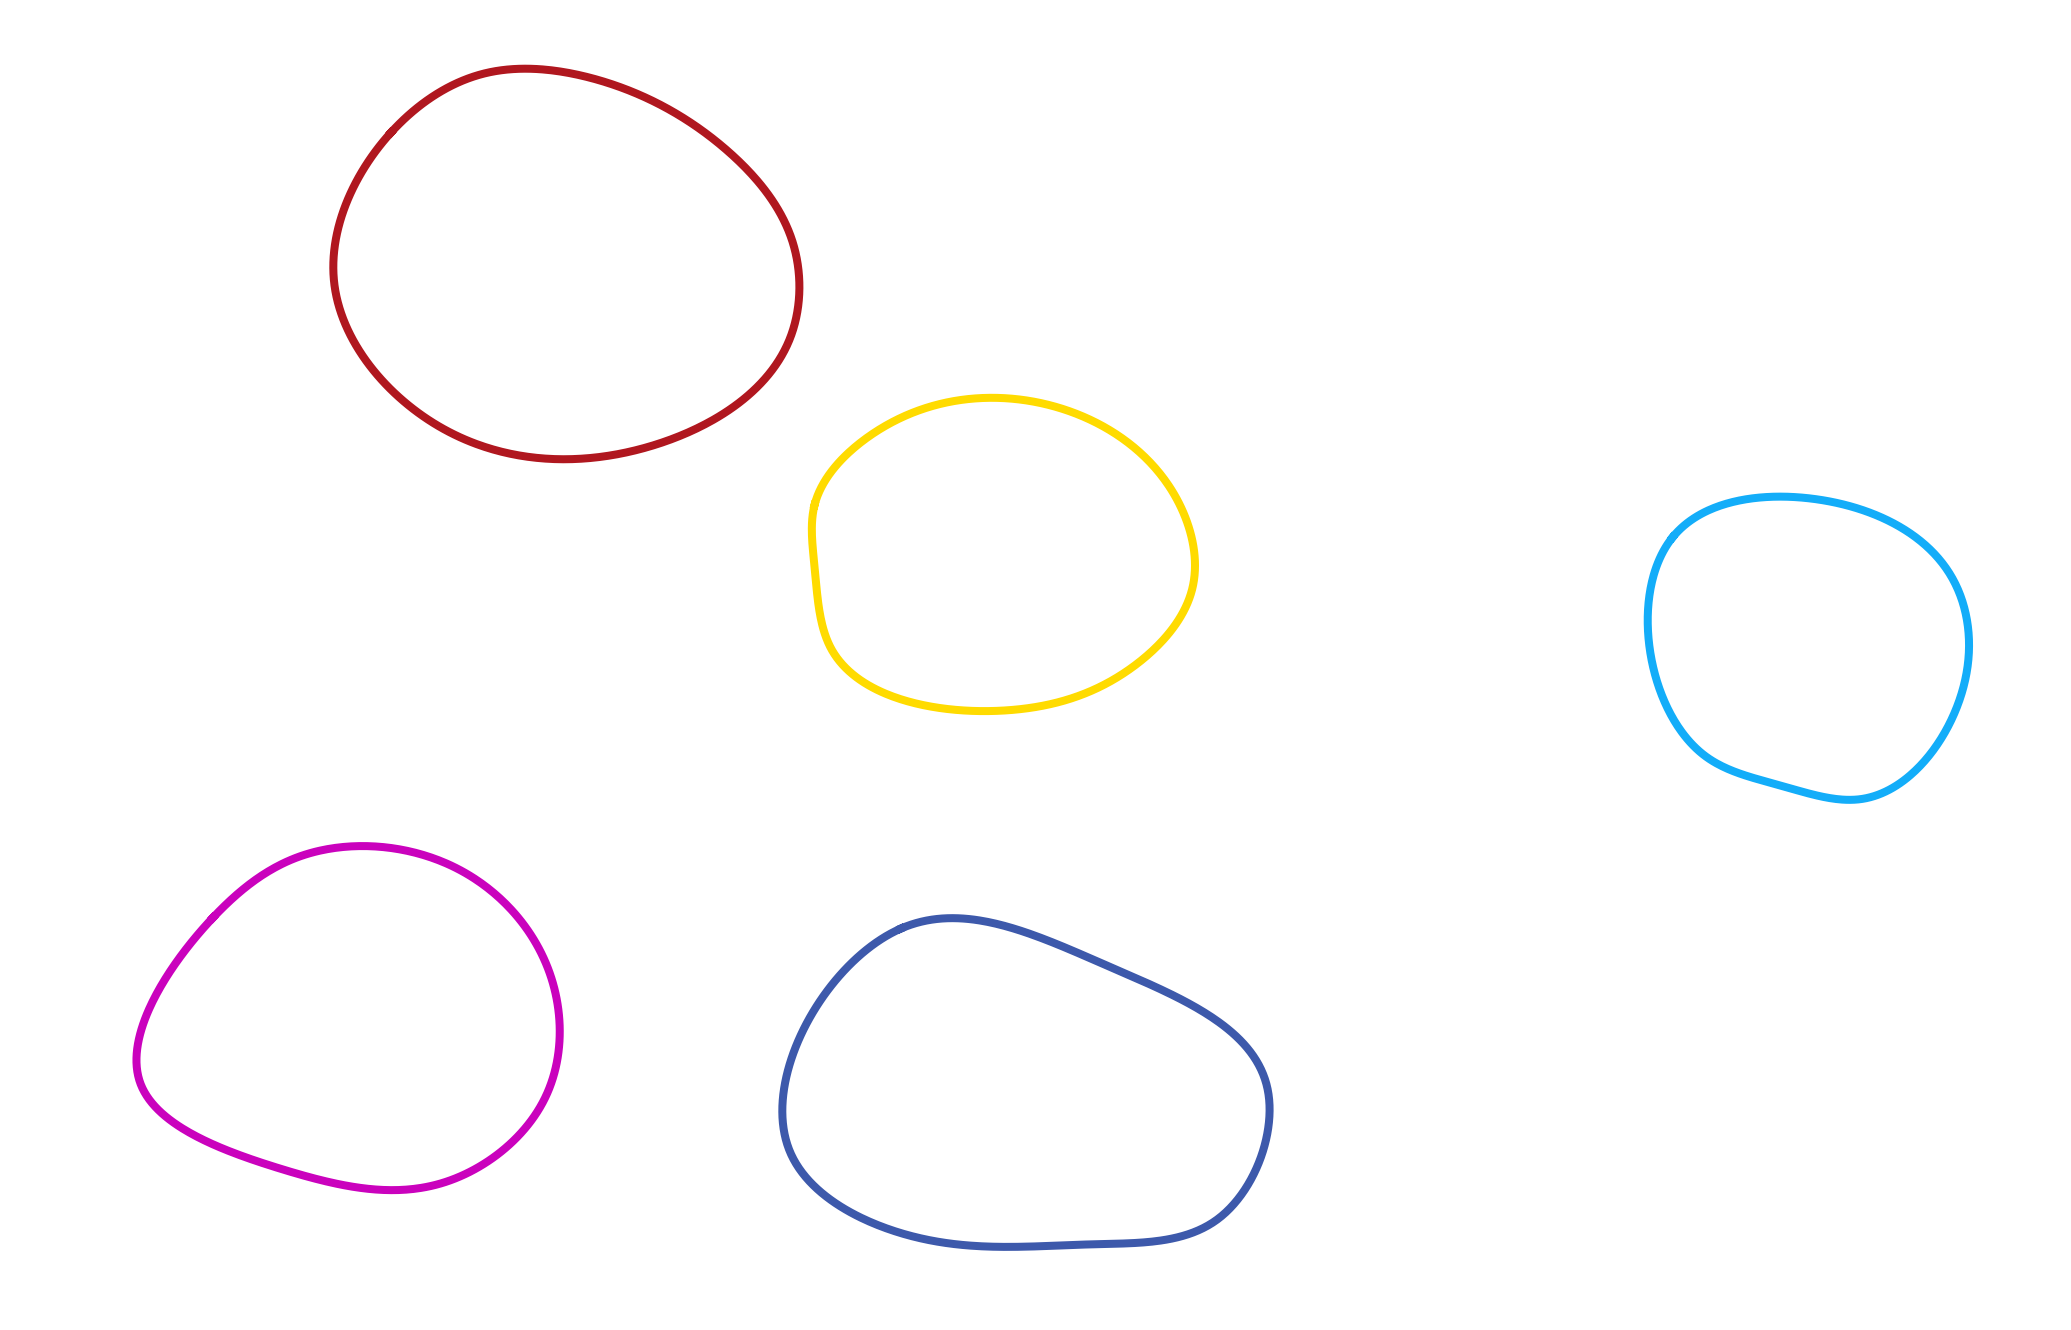

In [174]:
# plot training boundaries.
import vtk

def write_vtk(X, Y, filename):

    # Create three points. Join (Origin and P0) with a red line and
    # (Origin and P1) with a green line

    pts = vtk.vtkPoints()
    for x, y in zip(X, Y):
        #print(x, y)
        # Create a vtkPoints object and store the points in it
        pts.InsertNextPoint((x, y, elev[1800-int(y), int(x)]))

    # Create a cell array to store the lines in and add the lines to it
    lines = vtk.vtkCellArray()

    #origin = [0.0, 0.0, 0.0]
    #p0 = [1.0, 0.0, 0.0]
    #p1 = [0.0, 1.0, 0.0]
    for i in range(len(X)-1):

        # Create the first line (between Origin and P0)
        line = vtk.vtkLine()
        line.GetPointIds().SetId(0, i) # the second 0 is the index of the Origin in the vtkPoints
        line.GetPointIds().SetId(1, i+1) # the second 1 is the index of P0 in the vtkPoints

        lines.InsertNextCell(line)

    # Create the first line (between Origin and P0)
    line = vtk.vtkLine()
    line.GetPointIds().SetId(0, i+1) # the second 0 is the index of the Origin in the vtkPoints
    line.GetPointIds().SetId(1, 0) # the second 1 is the index of P0 in the vtkPoints
    lines.InsertNextCell(line)

    # Create a polydata to store everything in
    linesPolyData = vtk.vtkPolyData()

    # Add the points to the dataset
    linesPolyData.SetPoints(pts)

    # Add the lines to the dataset
    linesPolyData.SetLines(lines)

    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(linesPolyData)
    writer.SetFileName(filename)
    writer.Update()


# plot
fig = plt.figure(frameon=False)
fig.set_size_inches(5*9,2*9)
fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax.set_aspect("equal")
fig.add_axes(ax)
for i, the_class in enumerate(geoms):
    x, y = the_class.exterior.xy
    color = ag.map_class_ID_to_colour(i)
#    plt.plot(x, y, '-', color=color, lw=4)

    tck, u = splprep((x[:-1], y[:-1]), u=None, s=0.0, per=1) 
    u_new = np.linspace(u.min(), u.max(), 450)
    x_new, y_new = splev(u_new, tck, der=0)

    ax.plot(x_new, y_new, "-", color=color, lw=8)

    x_new = (x_new[:-1] - 133.5) / (136 - 133.5) * 3000
    y_new = (y_new[:-1] + 31.5) / 1.5 * 1800
    
   # x_new += 1880
   # y_new -= 1150
    
    print(y_new.min(), y_new.max())
    
    write_vtk(x_new, y_new, project_dir + '%i.vtk' % i)
#    ax.plot(x_new, y_new, "-", color=color, lw=8)

   # break
if 0:
    ax.plot((133.5, 136, 136, 133.5, 133.5), (-30, -30, -31.5, -31.5, -30))
    ax.set_xlim(133.5, 136)
    ax.set_ylim(-31.5, -30)


plt.savefig("/home/tom/csiro/src/lpr/projects/gawler/geoms.png", bbox_inches='tight', pad_inches=0, dpi=100)

In [147]:
project_dir = "/home/tom/csiro/src/lpr/projects/gawler/src/projects/gawler/"
np.savetxt(project_dir + "a.csv", np.array((x_new, y_new)).transpose(), header="x y", delimiter=",")

In [127]:
import vtk

def write_vtk(X, Y):

    # Create three points. Join (Origin and P0) with a red line and
    # (Origin and P1) with a green line

    pts = vtk.vtkPoints()
    for x, y in zip(X, Y):
        print(x, y)
        # Create a vtkPoints object and store the points in it
        pts.InsertNextPoint((x, y, 0))

    # Create a cell array to store the lines in and add the lines to it
    lines = vtk.vtkCellArray()

    #origin = [0.0, 0.0, 0.0]
    #p0 = [1.0, 0.0, 0.0]
    #p1 = [0.0, 1.0, 0.0]
    for i in range(len(X)-1):

        # Create the first line (between Origin and P0)
        line = vtk.vtkLine()
        line.GetPointIds().SetId(0, i) # the second 0 is the index of the Origin in the vtkPoints
        line.GetPointIds().SetId(1, i+1) # the second 1 is the index of P0 in the vtkPoints

        lines.InsertNextCell(line)

    # Create the first line (between Origin and P0)
    line = vtk.vtkLine()
    line.GetPointIds().SetId(0, i+1) # the second 0 is the index of the Origin in the vtkPoints
    line.GetPointIds().SetId(1, 0) # the second 1 is the index of P0 in the vtkPoints
    lines.InsertNextCell(line)

    # Create a polydata to store everything in
    linesPolyData = vtk.vtkPolyData()

    # Add the points to the dataset
    linesPolyData.SetPoints(pts)

    # Add the lines to the dataset
    linesPolyData.SetLines(lines)

    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(linesPolyData)
    writer.SetFileName(project_dir + 'mysphere.vtk')
    writer.Update()

2278.393954910814 1077.1433884362295
2355.119054887223 1123.9771988862658
2455.215157656471 1131.408519718174
2553.78498028615 1108.5900813212504
2632.687656150904 1058.1691523600582
2677.267593774104 980.2074176279475
2678.7551993841703 883.9613807306235
2637.4562687714047 789.8996102485313
2565.4878306699857 727.6819542369012
2477.026921494007 723.8527666690288
2384.452059344187 749.4907083623758
2304.8628947920292 794.2772790771841
2256.265963674059 882.7810763592083


In [2]:
filename = "/home/tom/csiro/src/lpr/projects/gawler/tmp/train/9151e7e9a626c090d61ed26cebe81806_size151,151_step25,25_small25,25_feat42.npz"
npz_file = np.load(filename)
feature_matrix = npz_file['feature_matrix']


feature_matrix.shape

(1805, 45)

In [3]:
hdr = ['eskewness', 'ekurtosis', 'eiqr', 'vbf0', 'vbf1', 'vbf2', 'vbf3', 'vbf4', 'vbf5', 'vbf6', 'vbf7', 'vbf8', 'vbf9', 'rtf0', 'rtf1', 'rtf2', 'rtf3', 'rtf4', 'rtf5', 'rtf6', 'rtf7', 'rtf8', 'rtf9', 'profcurv1', 'profcurv2', 'profcurv3', 'profcurv4', 'profcurv5', 'tmean', 'sskewness', 'skurtosis', 'siqr', 'wskewness', 'wkurtosis', 'wiqr', 'wmean', 'slopeLE', 'slopeVG', 'slopeGE', 'slopeMO', 'slopeST', 'slopeVS']
hdr += ['label', 'lat', 'lon']

In [4]:
if 1:
    train_df = pd.DataFrame(data=feature_matrix,    # values
    #              index=data[1:,0],    # 1st column as index
                  columns=hdr)  # 1st row as the column names
else:
    # or read from csv
    train_df = pd.read_csv("out.csv")

train_df.head()

eskewness  ekurtosis  eiqr      vbf0      vbf1      vbf2      vbf3  \
0   0.525428  -0.052801   5.0  0.038641  0.071934  0.054511  0.042781   
1   0.413834   0.337177   5.0  0.029536  0.054984  0.041799  0.032964   
2   0.381656   0.002598   5.0  0.024875  0.046308  0.035203  0.027984   
3   0.308167   0.046473   5.0  0.040688  0.067780  0.049985  0.038289   
4   0.341002   0.288733   5.0  0.039516  0.068633  0.053696  0.041879   

       vbf4      vbf5      vbf6    ...         wmean   slopeLE  slopeVG  \
0  0.070726  0.021908  0.555805    ...      1.018099  0.099017      0.0   
1  0.054852  0.017273  0.523470    ...      1.021242  0.093882      0.0   
2  0.046530  0.014992  0.445308    ...      1.013191  0.116713      0.0   
3  0.053684  0.016995  0.380986    ...      1.028387  0.089673      0.0   
4  0.062488  0.046323  0.368028    ...      1.031194  0.084988      0.0   

   slopeGE  slopeMO  slopeST  slopeVS  label         lat        lon  
0      0.0      0.0      0.0      0.0    0.0  133.999167 -30.073333  
1      0.0      0.0      0.0      0.0    0.0  134.020000 -30.073333  
2      0.0      0.0      0.0      0.0    0.0  134.040833 -30.073333  
3      0.0      0.0      0.0      0.0    0.0  134.061667 -30.073333  
4      0.0      0.0      0.0      0.0    0.0  134.082500 -30.073333  

[5 rows x 45 columns]

0.0 4.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


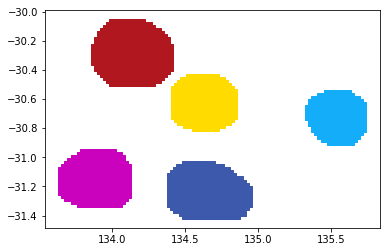

In [5]:

print (train_df.label.min(), train_df.label.max())
#var = df.slopeVG
levels = np.arange(11-0.5)
print (levels)
c_label = [ag.map_class_ID_to_colour(int(item)) for item in train_df.label]
plt.scatter(train_df.lat, train_df.lon, marker='s', edgecolors='face', c=c_label )


(array([451.,   0., 324.,   0.,   0., 359.,   0.,   0., 409.,   0., 262.]),
 array([0.        , 0.36363636, 0.72727273, 1.09090909, 1.45454545,
        1.81818182, 2.18181818, 2.54545455, 2.90909091, 3.27272727,
        3.63636364, 4.        ]),
 <a list of 11 Patch objects>)

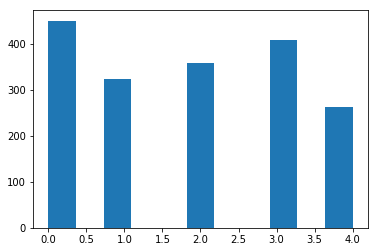

In [7]:
plt.hist(train_df.label, bins=11)


In [8]:
import sklearn
import copy
from sklearn import svm


In [9]:
# grab classified data only
df_labeled = copy.copy(train_df[train_df.label >= 0])
print(df_labeled.shape)
the_df = df_labeled
var = the_df.label - 0.5


(1805, 45)


# PCA
Run PCA on training data set. Dimensionality reduction: Project onto _n components_, evaluate explained variance.

Some classes separate nicely, while others overlap.

In [6]:
from sklearn.preprocessing import StandardScaler
n_components = 10

In [7]:
train_df.head()

eskewness  ekurtosis  eiqr      vbf0      vbf1      vbf2      vbf3  \
0   0.525428  -0.052801   5.0  0.038641  0.071934  0.054511  0.042781   
1   0.413834   0.337177   5.0  0.029536  0.054984  0.041799  0.032964   
2   0.381656   0.002598   5.0  0.024875  0.046308  0.035203  0.027984   
3   0.308167   0.046473   5.0  0.040688  0.067780  0.049985  0.038289   
4   0.341002   0.288733   5.0  0.039516  0.068633  0.053696  0.041879   

       vbf4      vbf5      vbf6    ...         wmean   slopeLE  slopeVG  \
0  0.070726  0.021908  0.555805    ...      1.018099  0.099017      0.0   
1  0.054852  0.017273  0.523470    ...      1.021242  0.093882      0.0   
2  0.046530  0.014992  0.445308    ...      1.013191  0.116713      0.0   
3  0.053684  0.016995  0.380986    ...      1.028387  0.089673      0.0   
4  0.062488  0.046323  0.368028    ...      1.031194  0.084988      0.0   

   slopeGE  slopeMO  slopeST  slopeVS  label         lat        lon  
0      0.0      0.0      0.0      0.0    0.0  133.999167 -30.073333  
1      0.0      0.0      0.0      0.0    0.0  134.020000 -30.073333  
2      0.0      0.0      0.0      0.0    0.0  134.040833 -30.073333  
3      0.0      0.0      0.0      0.0    0.0  134.061667 -30.073333  
4      0.0      0.0      0.0      0.0    0.0  134.082500 -30.073333  

[5 rows x 45 columns]

In [8]:
# remove label, s1, s2
features = [item for item in list(train_df.keys()) if item not in ['label', 'lat', 'lon']]
print("%i features" % len(features))

# Separating out the features
df = train_df
x = df.loc[:, features].values
        
# Separating out the target
y = df.loc[:,['label']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

42 features


In [9]:
from sklearn.decomposition import PCA

columns = ['PC%i' % (i) for i in range(n_components)]
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents,
                columns = columns)
final_df = pd.concat([principal_df, df[['label']]], axis = 1)
final_df.head()

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0 -4.421819 -2.956788 -1.672010  0.116058 -0.394455  2.237186 -0.440029   
1 -4.838878 -3.069307 -1.439306  0.004089 -0.501321  2.363261 -0.955244   
2 -4.981345 -3.314667 -1.300427 -0.203091 -0.723521  2.031428 -1.540286   
3 -4.636150 -3.223526 -1.571985  0.042733 -0.293249  1.893035 -1.577664   
4 -4.613400 -2.967154 -1.565828  0.299253 -0.275148  1.985543 -1.294222   

        PC7       PC8       PC9  label  
0 -0.801601  1.176308  1.662281    0.0  
1 -0.962284  0.898910  1.598906    0.0  
2 -1.022024  0.632623  1.218924    0.0  
3 -1.499884  0.613827  1.206182    0.0  
4 -1.528490  0.405661  1.116677    0.0

In [10]:
final_df

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0    -4.421819 -2.956788 -1.672010  0.116058 -0.394455  2.237186 -0.440029   
1    -4.838878 -3.069307 -1.439306  0.004089 -0.501321  2.363261 -0.955244   
2    -4.981345 -3.314667 -1.300427 -0.203091 -0.723521  2.031428 -1.540286   
3    -4.636150 -3.223526 -1.571985  0.042733 -0.293249  1.893035 -1.577664   
4    -4.613400 -2.967154 -1.565828  0.299253 -0.275148  1.985543 -1.294222   
5    -4.615054 -2.641429 -1.361132  0.260923 -0.467083  2.271241 -0.987188   
6    -4.700112 -2.315105 -1.246834  0.177807 -0.671718  2.562784 -0.629429   
7    -4.349657 -2.063094 -1.406680  0.213411 -0.703076  2.653825 -0.099077   
8    -4.023400 -1.851074 -1.967489  0.205098 -0.712490  2.228829  0.020177   
9    -4.109145 -1.677275 -1.957232  0.091465 -0.994897  2.278237  0.011641   
10   -3.945619 -1.680765 -1.854164 -0.108687 -0.969274  2.369840 -0.074769   
11   -4.694479 -2.768879 -2.319048 -0.096795 -0.818459  1.372703 -0.795976   
12   -4.541993 -2.692714 -2.335441  0.147822 -0.578185  1.399139 -0.781967   
13   -4.636003 -2.722489 -2.169344  0.195490 -0.507742  1.446749 -1.059743   
14   -4.711458 -2.919593 -1.915169  0.073437 -0.630882  1.350540 -1.376692   
15   -4.457309 -2.847517 -1.901520  0.357277 -0.272196  1.376114 -1.335413   
16   -4.311497 -2.704539 -1.835995  0.677858 -0.055428  1.576311 -1.074784   
17   -4.237468 -2.538839 -1.808384  0.524234 -0.219128  1.799183 -0.894608   
18   -4.153407 -2.354163 -1.767167  0.469181 -0.312046  2.062312 -0.544453   
19   -3.647117 -2.193784 -2.012432  0.523780 -0.343617  2.113156 -0.070426   
20   -3.328332 -1.978864 -2.505076  0.520728 -0.385664  1.612377 -0.211393   
21   -3.458512 -1.942784 -2.505540  0.297017 -0.780141  1.298270 -0.631886   
22   -3.506813 -1.925976 -2.286928  0.010701 -1.081473  1.027022 -1.015755   
23   -3.730432 -2.150535 -2.061740 -0.204208 -1.309585  0.891539 -1.463259   
24   -3.817711 -2.573865 -1.676280 -0.502116 -1.474806  0.989607 -1.931436   
25   -4.779762 -2.480599 -2.343368 -0.039905 -0.211717  2.328215 -0.288056   
26   -4.307346 -2.045342 -2.531076  0.458902  0.099405  2.042378 -0.184210   
27   -4.135567 -1.809449 -2.441100  0.632579  0.218628  2.078915 -0.047212   
28   -4.150991 -1.788627 -2.235918  0.772147  0.286259  2.034196 -0.258969   
29   -4.273618 -2.098686 -1.939190  0.628667  0.111185  2.033221 -0.503156   
...        ...       ...       ...       ...       ...       ...       ...   
1775 -3.755618 -3.214814  2.109111  1.428742  0.380188 -0.858253  1.406226   
1776 -3.679060 -2.931010  1.814676  1.480972  0.345519 -1.058246  1.284106   
1777 -3.536750 -2.898650  1.291402  1.549203  0.424815 -1.607117  0.914595   
1778 -3.458026 -3.060439  1.122067  1.320994  0.162546 -1.901977  0.570507   
1779 -3.425973 -2.884096  0.926526  1.781113  0.276727 -1.965338  0.108869   
1780 -3.331856 -2.738889  0.693489  2.221755  0.435761 -1.853650 -0.370230   
1781 -3.202849 -2.549166  0.203820  2.289403  0.306858 -1.666547 -0.535698   
1782 -3.012143 -2.535165 -0.017686  2.715722  0.515373 -1.339609 -0.723777   
1783 -2.580711 -2.303134 -0.278426  2.992568  0.494224 -0.960040 -0.861600   
1784 -2.202881 -1.890339 -0.583271  3.513481  0.584579 -0.702397 -0.917053   
1785 -1.942636 -1.948206 -1.284260  3.198952  0.539191  0.013783 -0.493323   
1786 -5.298829 -3.331635  2.360944  2.248539  0.858574 -1.483249  1.176325   
1787 -5.008875 -3.327233  2.646813  2.551314  0.992944 -1.416155  1.218563   
1788 -4.781650 -3.192098  2.136037  2.277393  0.837290 -1.581965  1.186998   
1789 -4.697174 -3.274872  1.725407  2.204526  0.855761 -1.954708  0.878308   
1790 -4.464713 -3.434471  1.708031  1.965186  0.588277 -2.064185  0.483390   
1791 -3.963268 -3.171230  1.390367  2.173466  0.466125 -2.040454  0.024206   
1792 -3.414519 -2.996776  0.855431  2.435718  0.624124 -1.961997 -0.459433   
1793 -3.018585 -2.692128  0.229724  2.448790  0.519041 -1.858245 -0.655688   
1794 -2.566689 -2.582837 -0.08196

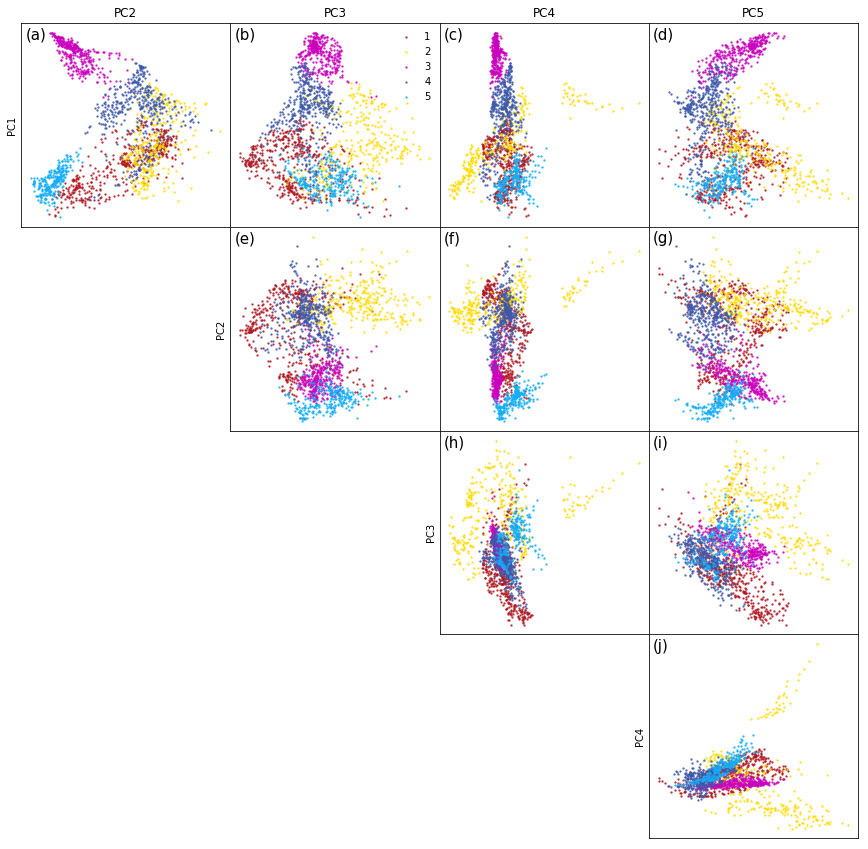

In [29]:
#fig = plt.figure(figsize = (8,8))
ni=4
nj=4
fig, axes = plt.subplots(ni, nj, figsize=(15,15))
class_IDs = np.array((0, 1, 2, 3, 4))
#class_IDs = np.array((0, 1, 3))
k=0
for i in range(ni):
    for j in range(nj):
        ax = axes[i,j]
        ax.set_xticks([])
        ax.set_yticks([])
        if j+1 <= i: 
            fig.delaxes(ax)
            continue

        PCx = 'PC%i' % (j+1)
        PCy = 'PC%i' % i
        if i == 0:
            ax.set_title('PC%i' % (j+1+1))
        if j == i:
            ax.set_ylabel('PC%i' % (i+1))
        #ax.set_title('%i component PCA' % n_components, fontsize = 15)

        for class_ID in class_IDs:
            color = ag.map_class_ID_to_colour(class_ID)
            indicesToKeep = final_df['label'] == class_ID
            ax.scatter(final_df.loc[indicesToKeep, PCx],
                       final_df.loc[indicesToKeep, PCy],
                       c=color, edgecolors="face",
                       s=2, alpha=0.7)
        subfl = "abcdefghijkl"[k]
        k += 1
        ax.text(0.02, 0.92, "("+subfl+")", transform=ax.transAxes, fontsize=15)


axes[0,1].legend(class_IDs+1, frameon=False, loc="upper right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("PCA_matrix.png", dpi=200)
plt.savefig("PCA_matrix.eps", dpi=200)
plt.savefig("PCA_matrix.pdf", dpi=200)

In [ ]:
plt.bar(xrange(n_components), pca.explained_variance_ratio_)
plt.xlabel("number of PC")
plt.ylabel("explained variance ratio")
print "explained variance using %i principal components: %g" % (n_components, pca.explained_variance_ratio_.sum())
#print pca.explained_variance_ratio_ 


## Direction of leading PC in feature space
Print components of leading PCA unit vectors in feature space. If any of them was dominated by a single feature, that feature could be used (in isolation) for classification. But none of the leading principal components are dominated  by a single feature.

In [ ]:
from operator import itemgetter
for i in range(3):
    print "PC", i
    data = zip(abs(pca.components_[i]), features)
    #print "unsort", data
    data.sort(key=itemgetter(0), reverse=True)
    for value, key in data[:5]:
        print "%5.3g" % value, key
    print


# Predict

In [ ]:
# take cl_df, run SVM
print train_df.shape
train_df.head()


In [ ]:
from sklearn import svm
features = [item for item in list(train_df.keys()) if item not in ['label', 's1', 's2']]
print "%i features" % len(features)
print features
# Separating out the features
df = train_df
X = df.loc[:, features].values
        
# Separating out the target
y = df.loc[:,['label']].values.ravel()



In [ ]:
clf = svm.SVC()
clf.fit(X, y)


In [ ]:
clf.predict([[2., 2.]])

# Repeat PCA for predicted dataset
- cl_df only has a subset of features, but all predictions.
- load full dataset, append prediction from cl_df



In [ ]:
# remove label, s1, s2

features = [item for item in list(cl_df.keys()) if item not in ['label', 's1', 's2']]
print "%i features" % len(features)

# Separating out the features
df = cl_df
x = df.loc[:, features].values
        
# Separating out the target
y = df.loc[:,['label']].values

# Standardizing the features
#x = StandardScaler().fit_transform(x)

In [ ]:
print len(cl_df), len(train_df)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents,
                columns = ['principal component 1', 'principal component 2'])
final_df = pd.concat([principal_df, df[['label']]], axis = 1)
final_df.head()

In [ ]:
class_colours = ['#888888', # gray
          '#b0171f', # red
          '#ffdb00', # yellow
          '#ca02bd', # dark pink
          '#3d59ab', # dark blue
          '#13adf9', # light blue
          '#3f7543', # dark green
          '#00cd66', # light green
          '#b99d00', # beige
          '#ff00ff'] # light pink

for i, col in enumerate(class_colours):
    plt.plot([0,1], [i,i], "-", lw=20, color=col)

In [175]:
_class_ID_to_cname = {
          -1: 'gray',
          0: 'red', # red
          1: 'yellow', # yellow
          2: 'dark_pink', # dark pink
          3: 'dark_blue', # dark blue
          4: 'light_blue', # light blue
          5: 'dark_green', # dark green
          6: 'light_green', # light green
          7: 'beige', # beige
          8: 'light_pink'} # light pink

_cname_to_colour = {
          'gray': '#888888',
          'red':'#b0171f', # red
          'yellow':'#ffdb00', # yellow
          'dark_pink':'#ca02bd', # dark pink
          'dark_blue':'#3d59ab', # dark blue
          'light_blue':'#13adf9', # light blue
          'dark_green':'#3f7543', # dark green
          'light_green':'#00cd66', # light green
          'beige':'#b99d00', # beige
          'light_pink':'#ff70ff'} # light pink


In [176]:
from common import map_class_ID_to_colour

In [195]:
for classID in range(5):
    hexcol = map_class_ID_to_colour(classID)[1:]
    print(classID, "%3i %3i %3i" % (int(hexcol[0:2], 16), int(hexcol[2:4], 16), int(hexcol[4:6], 16)))


0 176  23  31
1 255 219   0
2 202   2 189
3  61  89 171
4  19 173 249
